In [1]:
%cd '/content/drive/MyDrive/Movie Rating Prediction/Sentiment Analysis'

/content/drive/MyDrive/Movie Rating Prediction/Sentiment Analysis


In [2]:
# !unzip 'IMDB Dataset.csv.zip'

In [3]:
!nvidia-smi


Wed Jun 23 02:15:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# !pip install pytorch-transformers

In [5]:
pip install transformers==2.11.0

     |████████████████████████████████| 675kB 9.5MB/s 
     |████████████████████████████████| 901kB 48.9MB/s 
     |████████████████████████████████| 1.2MB 48.4MB/s 
     |████████████████████████████████| 5.6MB 49.5MB/s 


In [6]:
!pip install -q -U watermark


In [7]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.9.0+cu102
transformers: 2.11.0



In [8]:
import transformers

from transformers import  XLNetModel, AdamW, get_linear_schedule_with_warmup , XLNetTokenizer

# from pytorch_transformers import  XLNetTokenizer #, XLNetForSequenceClassification , XLNetModel
# from pytorch_transformers import AdamW

import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [9]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:

df1 = pd.read_csv('userReviews.csv')
df1.head()

,movie,user_review,user_rating
0,The Dark Knight,"Confidently directed, dark, brooding, and pack...",10
1,The Dark Knight,Best movie ever. Heath ledger's work is phenom...,10
2,The Dark Knight,Totally one of the greatest movie titles ever ...,10
3,The Dark Knight,It is just what you want for the best movie. G...,10
4,The Dark Knight,I got to see The Dark Knight on Wednesday nigh...,10


In [11]:
# df = pd.read_csv('IMDB Dataset.csv')
# df.head()

import sqlite3
import pandas as pd
# Create your connection.
cnx = sqlite3.connect("Kaggle's dataset/IMDB_Movies_2021.db")

df2 = pd.read_sql_query("SELECT * FROM REVIEWS", cnx)

In [12]:
df2 = pd.DataFrame({'review' : df2.REVIEW , 'sentiment' : df2.RATING})

In [13]:
df2.sentiment = df2.sentiment.astype(np.float64)

In [14]:

df1 = pd.DataFrame({'review' : df1.user_review , 'sentiment' : df1.user_rating})

In [15]:
df = pd.concat((df1, df2), axis=0)

In [16]:
df.sentiment -= 1 

In [17]:
df.sentiment = df.sentiment.astype(np.float64)

In [18]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head(10)

,review,sentiment
1941,I think this is cool for 1st time korean block...,7.0
4249,This has ZERO to do with the book. The only si...,0.0
2234,I haven't even finished watching this movie bu...,NaN
3206,I recently saw the movie in theaters with my b...,6.0
189,I would have given 0 stars if it was possible!...,0.0
2119,So few movies today capture the emotion and ar...,8.0
3926,An incredibly boring and forgettable film with...,1.0
1520,Excellent making of a cyber crime thriller wit...,NaN
932,"I love a good Thriller, and when theirs a real...",5.0
4066,Everyone who watches this movie knows what the...,8.0


In [19]:
# df = df[:24000]

len(df)

7125

In [20]:
df.dropna(axis = 0 , inplace = True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7007 entries, 1941 to 860
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   review     7007 non-null   object 
 1   sentiment  7007 non-null   float64
dtypes: float64(1), object(1)
memory usage: 164.2+ KB


In [22]:

import re
def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

In [23]:
df['review'] = df['review'].apply(clean_text)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


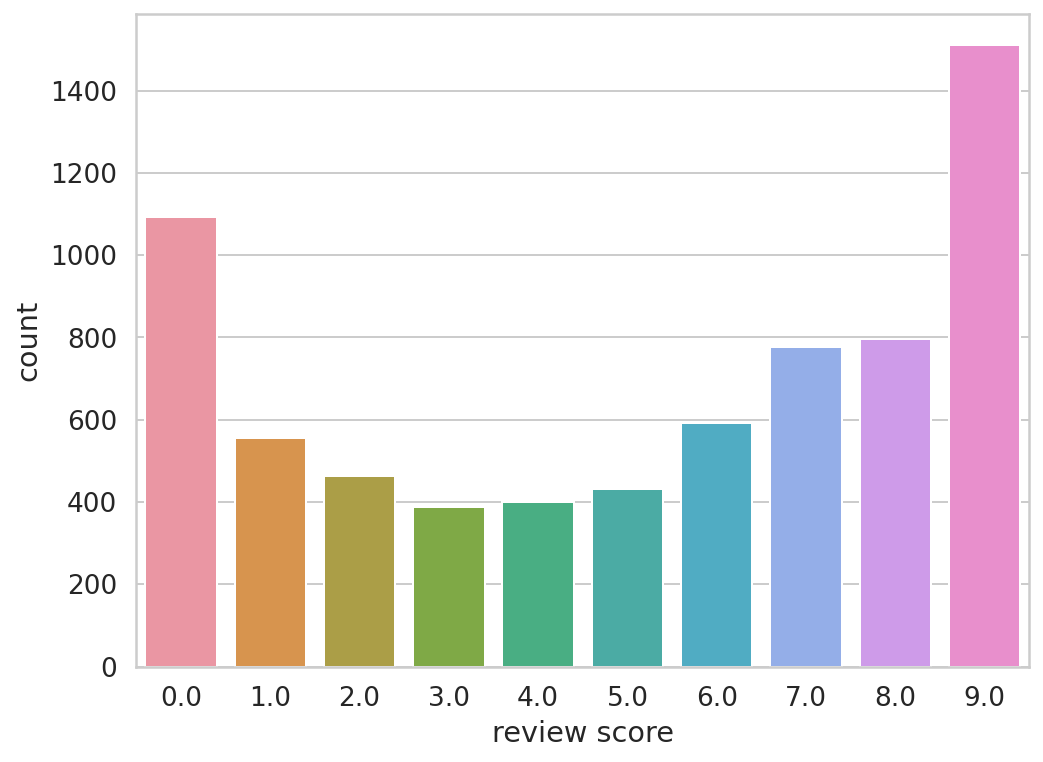

In [24]:
rcParams['figure.figsize'] = 8, 6
sns.countplot(df.sentiment)
plt.xlabel('review score');

In [25]:
def sentiment2label(sentiment):
    if sentiment == 0 or sentiment == 1:
        return 0
    elif sentiment == 2 or sentiment == 3:
        return 1
    elif sentiment == 4 or sentiment == 5:
        return 2
    elif sentiment == 6 or sentiment == 7:
        return 3
    elif sentiment == 8 or sentiment == 9:
        return 4



df['sentiment'] = df['sentiment'].apply(sentiment2label)

In [26]:
df['sentiment'].value_counts()


4    2306
0    1648
3    1370
1     851
2     832
Name: sentiment, dtype: int64

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7007 entries, 1941 to 860
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     7007 non-null   object
 1   sentiment  7007 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 324.2+ KB


In [28]:
class_names = [str(i) for i in range(5)]


In [29]:
from transformers import XLNetTokenizer, XLNetModel
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [30]:
input_txt = "India is my country. All Indians are my brothers and sisters"
encodings = tokenizer.encode_plus(input_txt, add_special_tokens=True, max_length=16, return_tensors='pt', return_token_type_ids=False, return_attention_mask=True, pad_to_max_length=False)

In [31]:
print('input_ids : ',encodings['input_ids'])


input_ids :  tensor([[ 837,   27,   94,  234,    9,  394, 7056,   41,   94, 4194,   21, 8301,
            4,    3]])


In [32]:
tokenizer.convert_ids_to_tokens(encodings['input_ids'][0])


['▁India',
 '▁is',
 '▁my',
 '▁country',
 '.',
 '▁All',
 '▁Indians',
 '▁are',
 '▁my',
 '▁brothers',
 '▁and',
 '▁sisters',
 '<sep>',
 '<cls>']

In [33]:
type(encodings['attention_mask'])


torch.Tensor

In [34]:
attention_mask = pad_sequences(encodings['attention_mask'], maxlen=512, dtype=torch.Tensor ,truncating="post",padding="post")


In [35]:

attention_mask = attention_mask.astype(dtype = 'int64')
attention_mask = torch.tensor(attention_mask) 
attention_mask.flatten()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [36]:
encodings['input_ids']


tensor([[ 837,   27,   94,  234,    9,  394, 7056,   41,   94, 4194,   21, 8301,
            4,    3]])

In [37]:
token_lens = []

for txt in df['review']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


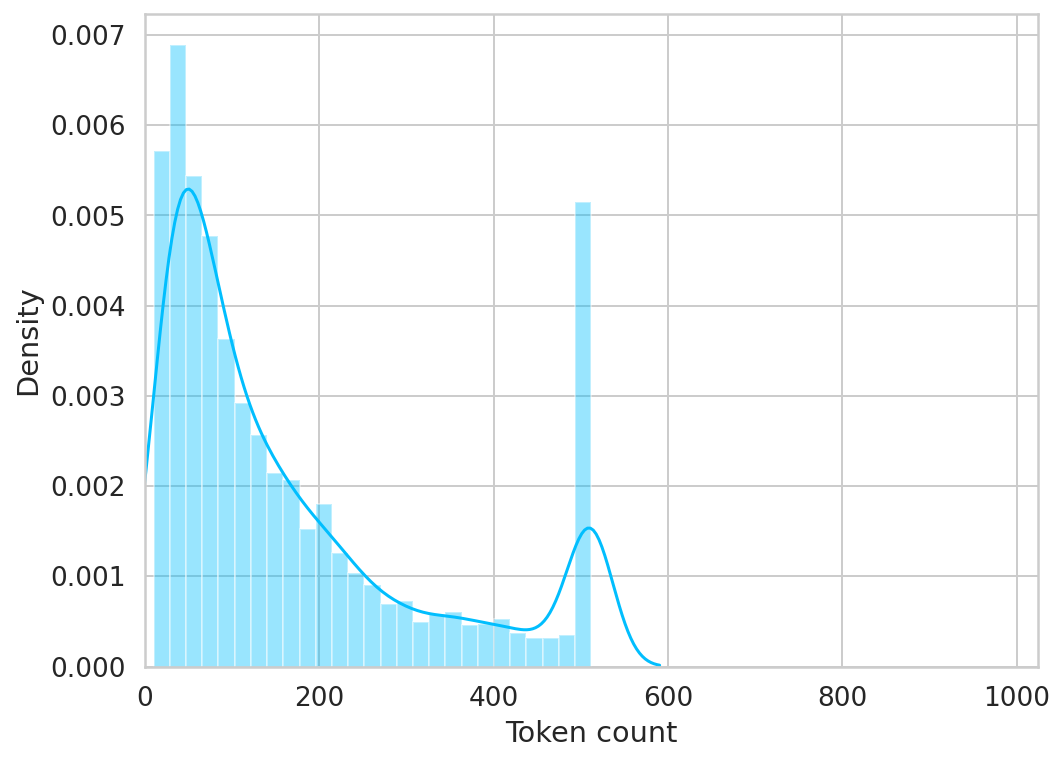

In [38]:
sns.distplot(token_lens)
plt.xlim([0, 1024]);
plt.xlabel('Token count');

In [39]:
MAX_LEN = 512


In [40]:
class ImdbDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {
        'review_text': review,
        'input_ids': input_ids,
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }

In [41]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=101)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=101)

In [42]:
df_train.shape, df_val.shape, df_test.shape

((6306, 2), (350, 2), (351, 2))

In [43]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ImdbDataset(
    reviews=df.review.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [44]:
BATCH_SIZE = 4

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [45]:
from transformers import XLNetForSequenceClassification
from transformers import XLNetConfig


# config = XLNetConfig.from_pretrained("xlnet-base-cased", num_labels=1)
# model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", config=config)


model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 5)
model = model.to(device)

In [46]:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [47]:
EPOCHS = 10

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [48]:
# # (iter(train_data_loader))

# *_  , last = iter(train_data_loader) # for a better understanding check PEP 448
# data = last
# data.keys()


In [49]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [50]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)
print(input_ids.reshape(4,512).shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([4, 512])
torch.Size([4, 512])


In [51]:
input_ids[0]

tensor([[ 4065,    18,   468,    27, 15178,   938,    21,    18,   257,   811,
            27, 11683,     9,   476,    21,    29,    26,    23,    24,   534,
         23760, 24296,   113,    24,  7980,   136,    32,  2512,  7641,  1224,
            18,   219,   116,  5783,    49,   929,   769,   113,   102,   545,
             9, 25509,   115,   886,   603,    22,    17,  5824,    21,    63,
           125,   140,    24,  4948,    78,    20,    36,     9,     9,     9,
             9,     4,     3,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [52]:
outputs = model(input_ids.reshape(4,512), token_type_ids=None, attention_mask=attention_mask, labels=targets)
outputs

(tensor(1.7743, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor([[ 0.1106, -0.2012,  0.8985, -0.3707, -0.4792],
         [ 0.0582, -0.1574,  0.7294, -0.3224, -0.2621],
         [ 0.1448, -0.2787,  0.7421, -0.3645, -0.4034],
         [ 0.2147, -0.2376,  0.6943, -0.3769, -0.2748]], device='cuda:0',
        grad_fn=<AddmmBackward>))

In [53]:
type(outputs[0])

torch.Tensor

In [54]:
from sklearn import metrics
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0
    l = len(iter(data_loader))
  
    for d in data_loader:
        if counter < l-1:
            input_ids = d["input_ids"].reshape(4,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            # preds = preds.cpu().detach().numpy()
            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            counter = counter + 1

    return acc / counter, np.mean(losses)

In [55]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
    l = len(iter(data_loader))
    
    with torch.no_grad():
        for d in data_loader:
          if counter < l-1:
            input_ids = d["input_ids"].reshape(4,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)

In [57]:
# TRAINING CELL

# %%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,     
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader, 
        device, 
        len(df_val)
    )

    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), '/content/drive/MyDrive/Movie Rating Prediction/Sentiment Analysis/models/xlnet_model_5-Classification.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.8968489311238382 Train accuracy 0.6427664974619289
Val loss 0.826458830257942 Val accuracy 0.6781609195402298

Epoch 2/10
----------
Train loss 0.7410271243958411 Train accuracy 0.7311230964467005
Val loss 1.1378593256525782 Val accuracy 0.6264367816091954

Epoch 3/10
----------
Train loss 0.6274941802824975 Train accuracy 0.8125
Val loss 1.7471510692868895 Val accuracy 0.6235632183908046

Epoch 4/10
----------


KeyboardInterrupt: ignored

In [58]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Movie Rating Prediction/Sentiment Analysis/models/xlnet_model_5-Classification.bin'))


<All keys matched successfully>

In [59]:
model = model.to(device)


In [60]:
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  device,
  len(df_test)
)

print('Test Accuracy :', test_acc)
print('Test Loss :', test_loss)

Test Accuracy : 0.5747126436781609
Test Loss : 0.9912077138821284


In [61]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    counter = 0
    l = len(iter(data_loader))
    with torch.no_grad():
        for d in data_loader:
          if counter < l-1:

            texts = d["review_text"]
            input_ids = d["input_ids"].reshape(4,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)

            loss = outputs[0]
            logits = outputs[1]
            
            _, preds = torch.max(outputs[1], dim=1)

            probs = F.softmax(outputs[1], dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)
            counter = counter+1

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [62]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [63]:
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

           0       0.68      0.74      0.71        91
           1       0.22      0.22      0.22        41
           2       0.35      0.41      0.38        41
           3       0.51      0.47      0.49        70
           4       0.78      0.70      0.74       105

    accuracy                           0.57       348
   macro avg       0.51      0.51      0.51       348
weighted avg       0.58      0.57      0.58       348



In [66]:
def predict_sentiment(text):
    review_text = text

    encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=False,
    return_attention_mask=True,
    return_tensors='pt',
    )

    input_ids = pad_sequences(encoded_review['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    input_ids = input_ids.astype(dtype = 'int64')
    input_ids = torch.tensor(input_ids) 

    attention_mask = pad_sequences(encoded_review['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    attention_mask = attention_mask.astype(dtype = 'int64')
    attention_mask = torch.tensor(attention_mask) 

    input_ids = input_ids.reshape(1,512).to(device)
    attention_mask = attention_mask.to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    outputs = outputs[0][0].cpu().detach()

    probs = F.softmax(outputs, dim=-1).cpu().detach().numpy().tolist()
    _, prediction = torch.max(outputs, dim =-1)

    print("1:", probs[0])
    print("2", probs[1])
    print("3:", probs[2])
    print("4:", probs[3])
    print("5:", probs[4])
    # print("6:", probs[5])
    # print("7:", probs[6])
    # print("8:", probs[7])
    # print("9:", probs[8])
    # print("10:", probs[9])
    
    print(f'Review text: {review_text}')
    print(f'Sentiment  : {str(int(class_names[prediction] )+1 ) }' ) 

In [67]:
text = "Movie is the worst one I have ever seen!! The story has no meaning at all"
predict_sentiment(text)

1: 0.9623836278915405
2 0.03090801276266575
3: 0.002467027399688959
4: 0.00044735593837685883
5: 0.0037940838374197483
Review text: Movie is the worst one I have ever seen!! The story has no meaning at all
Sentiment  : 1


In [68]:
text = "This is the best movie I have ever seen!! The story is such a motivation"
predict_sentiment(text)

1: 0.0011470274766907096
2 0.00044818437891080976
3: 0.0008688537636771798
4: 0.035976190119981766
5: 0.9615597724914551
Review text: This is the best movie I have ever seen!! The story is such a motivation
Sentiment  : 5


In [69]:
text = "the acting was the best from my favorite actor. The story was bizarre though. The acting of other actors was  so less inspiring"
predict_sentiment(text)

1: 0.2489500790834427
2 0.43654412031173706
3: 0.26644396781921387
4: 0.032769061625003815
5: 0.015292846597731113
Review text: the acting was the best from my favorite actor. The story was bizarre though. The acting of other actors was  so less inspiring
Sentiment  : 2
